1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


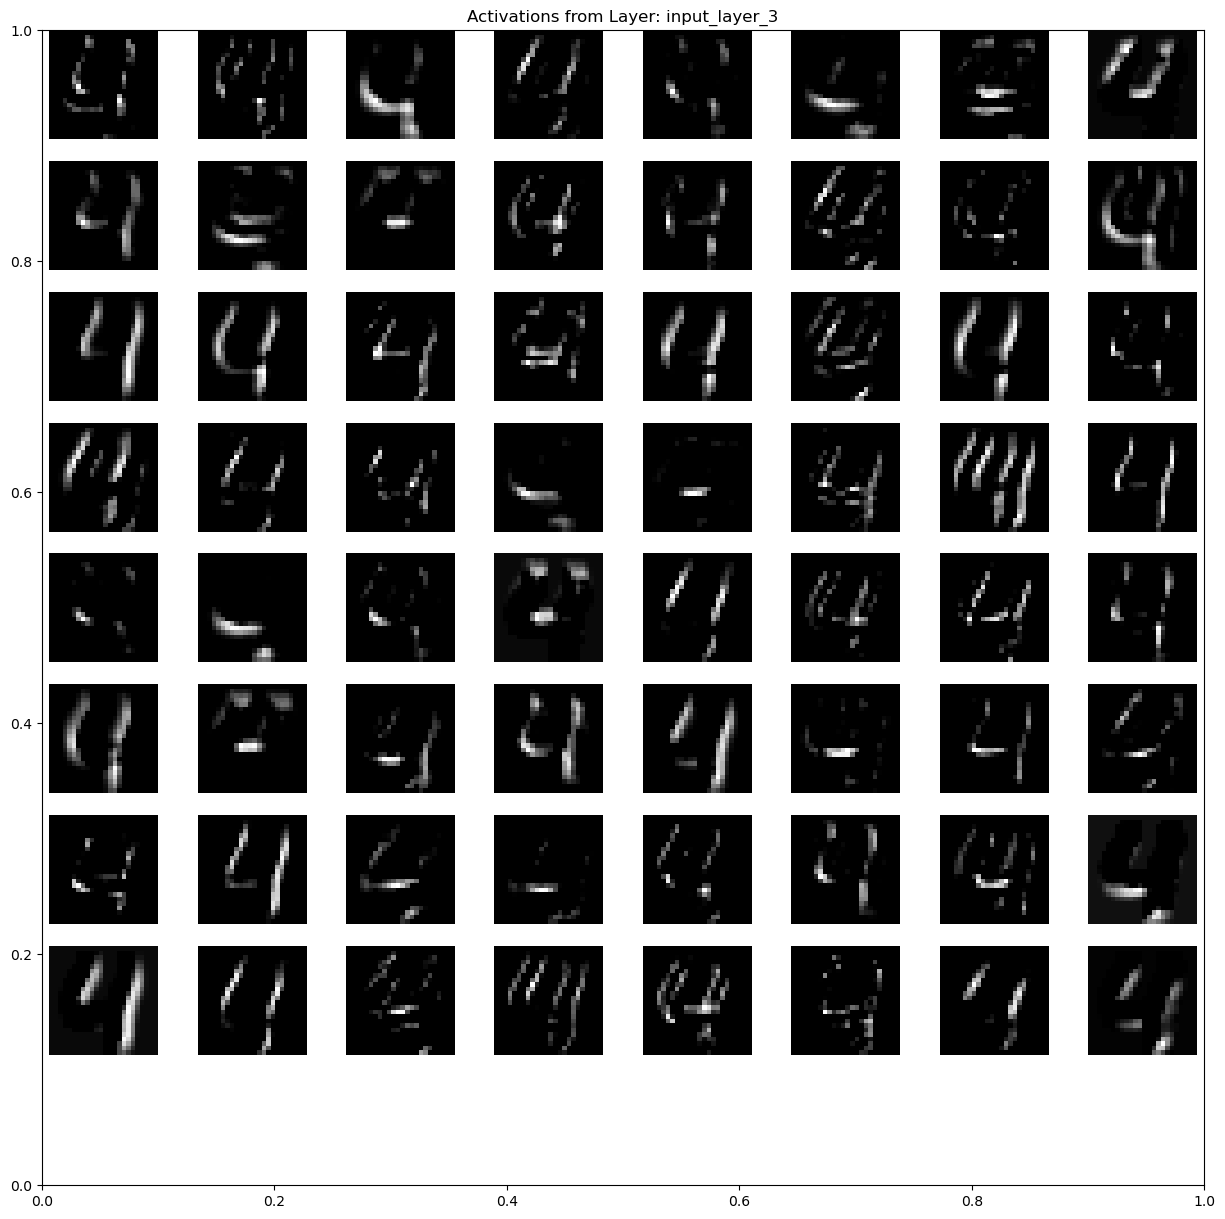

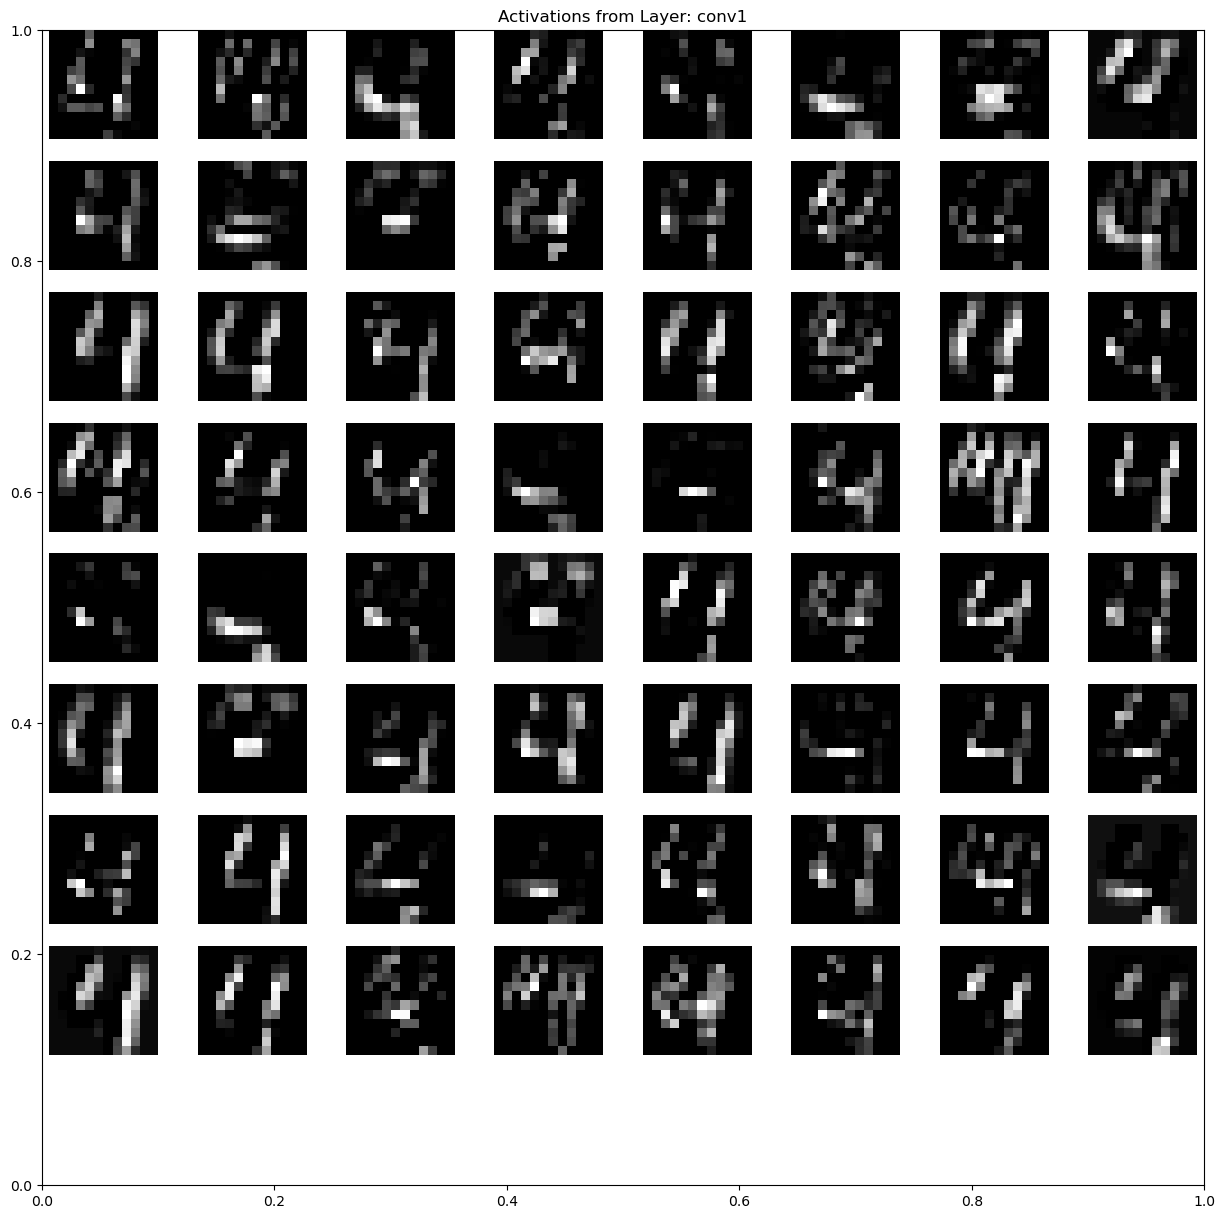

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the CNN model
input_layer = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', name='conv1')(input_layer)
x = layers.MaxPooling2D((2, 2), name='pool1')(x)
x = layers.Flatten()(x)
output_layer = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        logs['test_accuracy'] = test_acc
        #print(f'\nTest accuracy after epoch {epoch + 1}: {test_acc:.4f}')
# Train the model for 20 epochs and store history
validation_size = 5000
total_train_size = 55000  # 設置為55,000
validation_split = validation_size / total_train_size  # 計算驗證集佔比

# 訓練模型
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=validation_split, verbose=0, callbacks=[TestAccuracyCallback()])


# Create a new model that outputs each layer's activations
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D))]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Select a test image and get activations
sample_input = x_test[4:5]  # use no.5 image as a sample

# use predict to get activation
activations = activation_model.predict(sample_input)

# show the feature image
for i, activation in enumerate(activations):
    plt.figure(figsize=(15, 15))
    plt.title(f'Activations from Layer: {activation_model.layers[i].name}')
    num_features = activation.shape[-1]  # # of features
    for j in range(num_features):
        plt.subplot(num_features // 8 + 1, 8, j + 1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    #plt.savefig(f'i.png')
    plt.show()


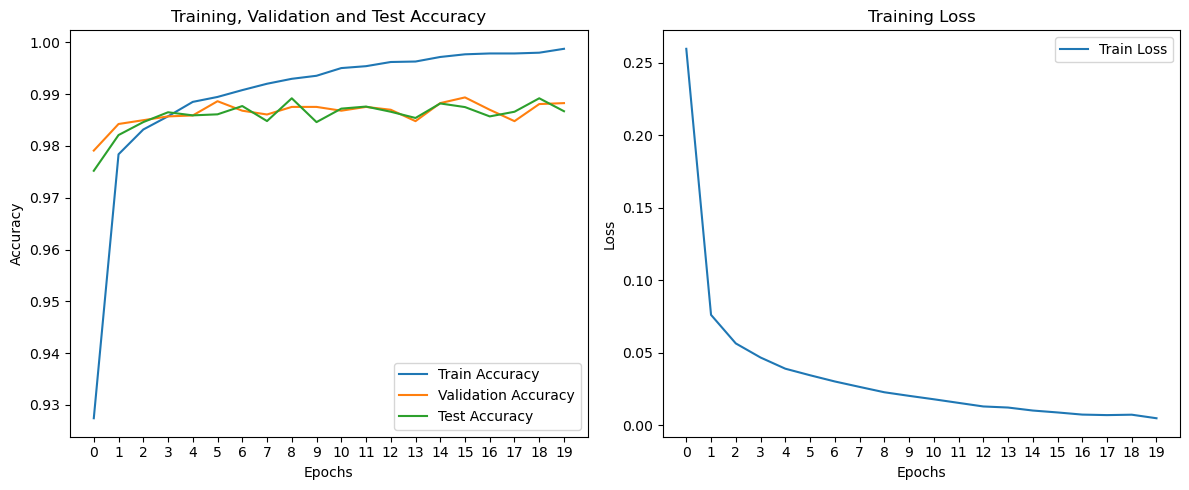

In [13]:
# Plot the accuracy 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['test_accuracy'], label='Test Accuracy') 
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(history.history['accuracy'])))
plt.legend()

# plot loss function
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(history.history['accuracy'])))
plt.legend()

plt.tight_layout()
plt.show()

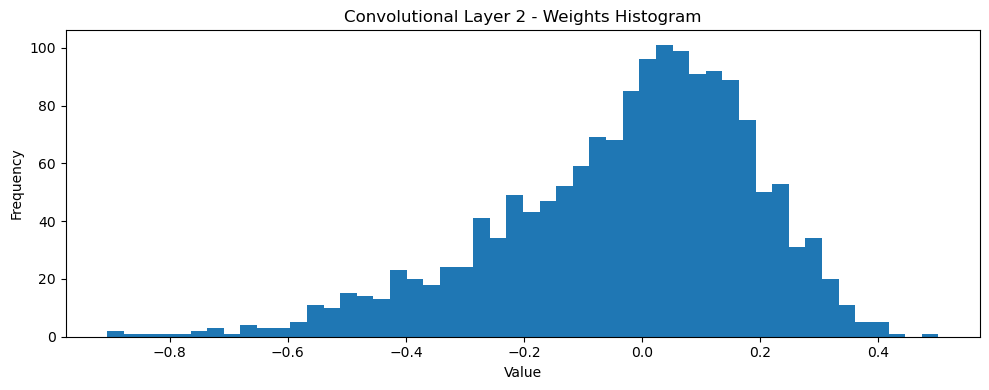

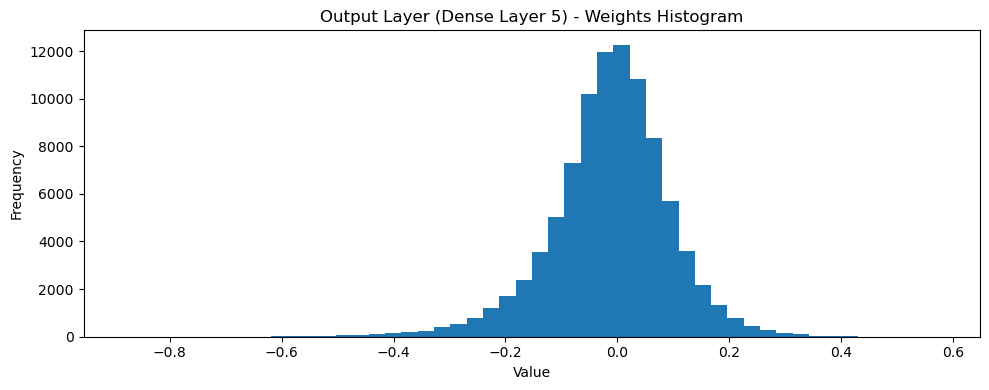

In [21]:

def plot_weights_histograms(model):
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if weights: 
            weight_values = weights[0].flatten()

            # check the name of layer
            layer_type = layer.__class__.__name__
            if layer_type == 'Conv2D':
                layer_title = f'Convolutional Layer {i + 1}'
            elif layer_type == 'Dense':
                if i == len(model.layers) - 1:  # 最後一層為輸出層
                    layer_title = f'Output Layer (Dense Layer {i + 1})'
                else:
                    layer_title = f'Dense Layer {i + 1}'
            else:
                continue  # skip unusful layer
            # plot the histogram
            plt.figure(figsize=(10, 4))
            plt.hist(weight_values, bins=50)
            plt.title(f'{layer_title} - Weights Histogram')
            plt.xlabel('Value')
            plt.ylabel('Frequency')

            plt.tight_layout()
            plt.show()

plot_weights_histograms(model)  

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


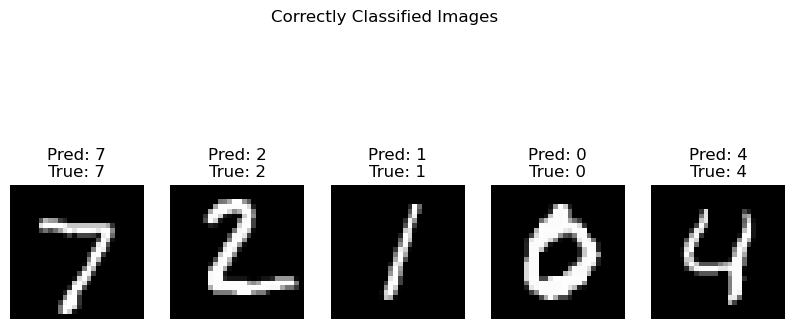

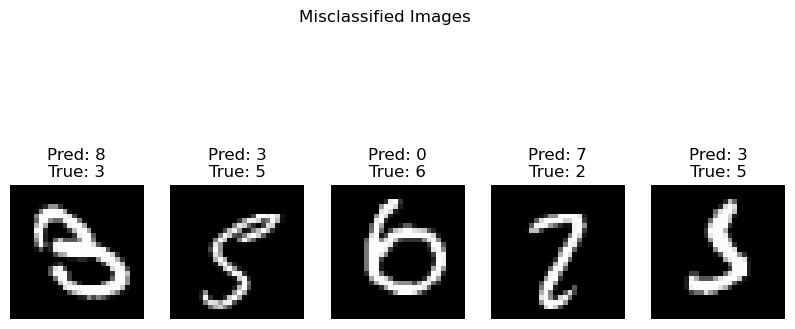

In [14]:
# compare  with real result
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# find correct and incorrect index
correct_indices = np.where(predicted_labels == y_test)[0]
incorrect_indices = np.where(predicted_labels != y_test)[0]

# show some correctly classified result 
plt.figure(figsize=(10, 5))
for i, idx in enumerate(correct_indices[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted_labels[idx]}\nTrue: {y_test[idx]}")
    plt.axis('off')
plt.suptitle("Correctly Classified Images")
plt.show()

# show some incorrect result
plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect_indices[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted_labels[idx]}\nTrue: {y_test[idx]}")
    plt.axis('off')
plt.suptitle("Misclassified Images")
plt.show()


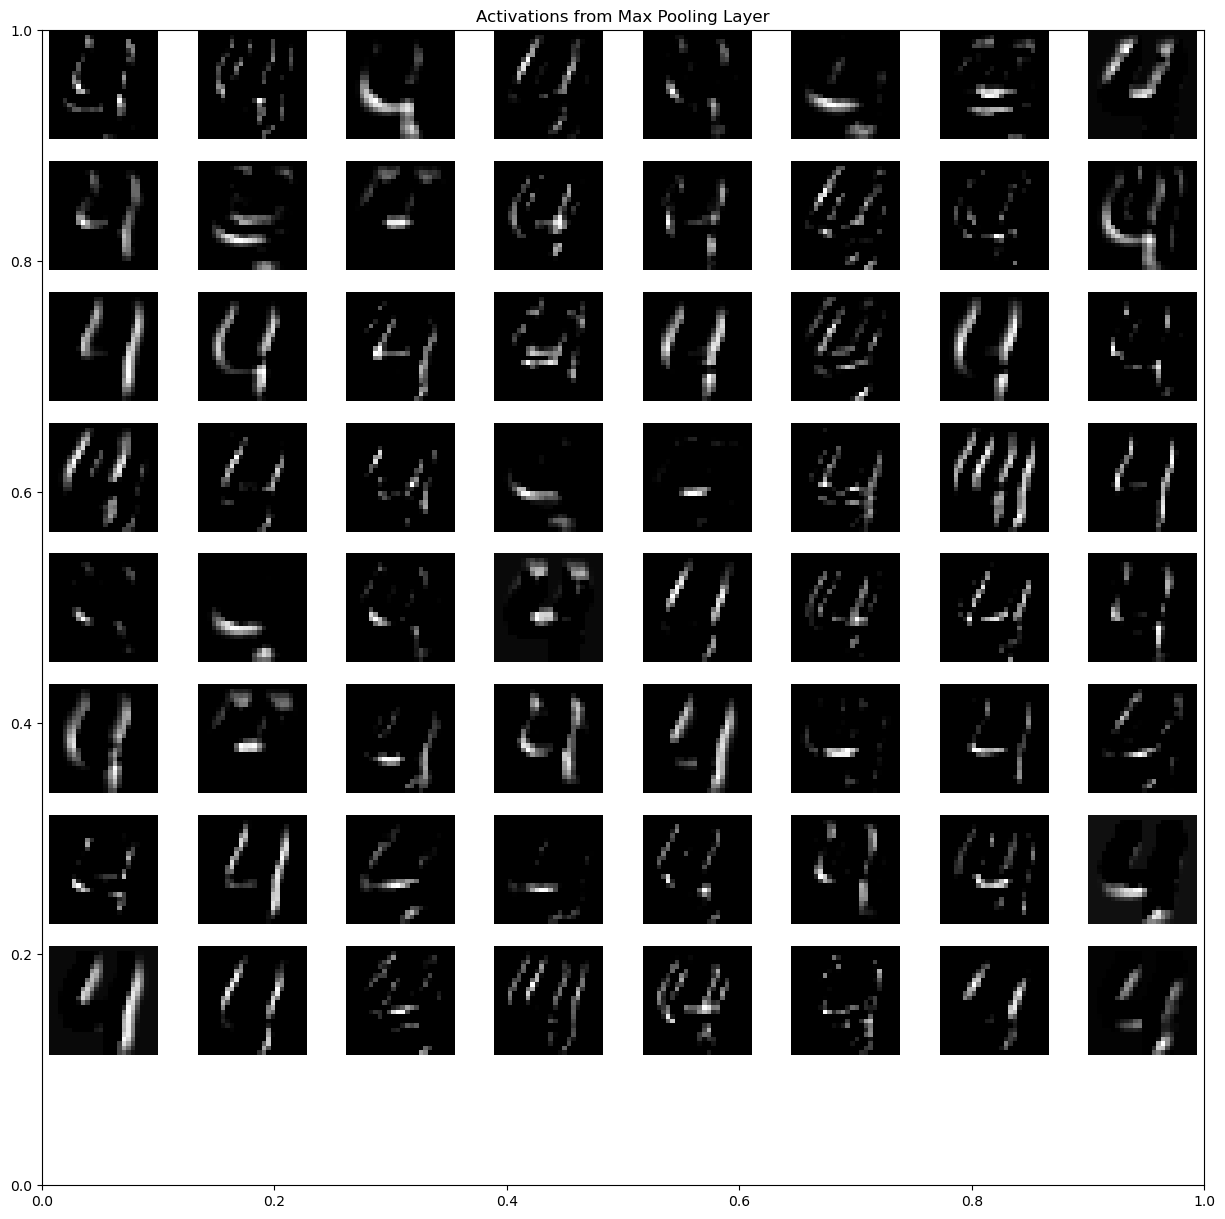

In [20]:
activation = activations[0]  # get figure image
num_features = activation.shape[-1]  # # of features
plt.figure(figsize=(15, 15))
plt.title('Activations from Max Pooling Layer')
for j in range(num_features):
    plt.subplot(num_features // 8 + 1, 8, j + 1)
    plt.imshow(activation[0, :, :, j], cmap='gray')
    plt.axis('off')
plt.show()


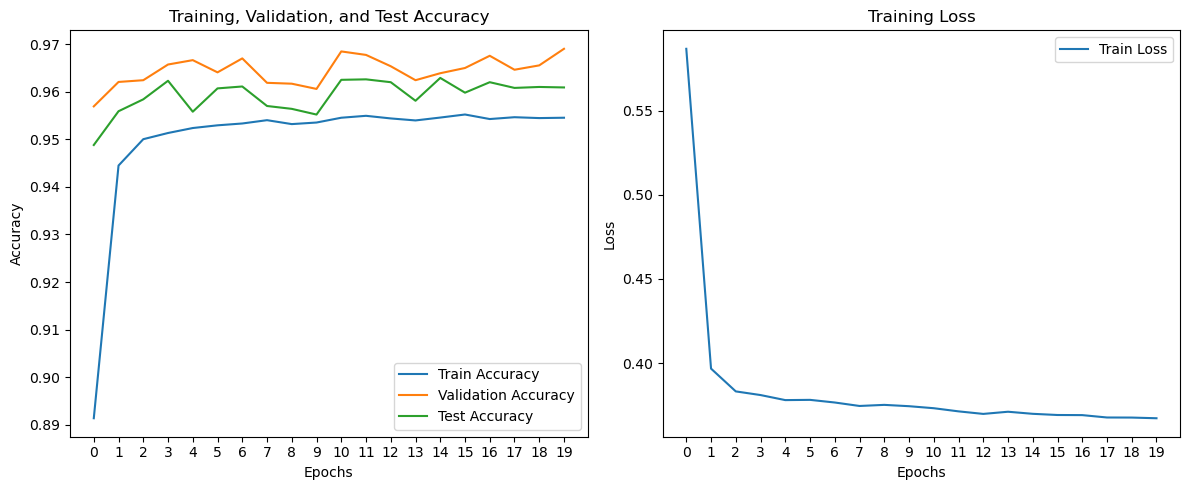

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the CNN model with L2 regularization
input_layer = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (5, 5), strides=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01), name='conv1')(input_layer)
x = layers.MaxPooling2D((2, 2), name='pool1')(x)
x = layers.Flatten()(x)
output_layer = layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
model_with_l2 = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_l2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback to store test accuracy at each epoch end
class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        self.test_accuracies.append(test_acc)
        #print(f'\nTest accuracy after epoch {epoch + 1}: {test_acc:.4f}')

test_accuracy_callback = TestAccuracyCallback()

# Train the model and store history
history_with_l2 = model_with_l2.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=1/11,
    callbacks=[test_accuracy_callback],
    verbose=0
)

# Plot the accuracies
plt.figure(figsize=(12, 5))

# Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_with_l2.history['accuracy'], label='Train Accuracy')
plt.plot(history_with_l2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(test_accuracy_callback.test_accuracies, label='Test Accuracy')  # 使用 TestAccuracyCallback 中的測試準確率列表
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(history_with_l2.history['accuracy'])))  # 將 Epochs 設定為整數刻度
plt.legend()

# Training loss
plt.subplot(1, 2, 2)
plt.plot(history_with_l2.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(history_with_l2.history['loss'])))  # 將 Epochs 設定為整數刻度
plt.legend()

plt.tight_layout()
plt.show()


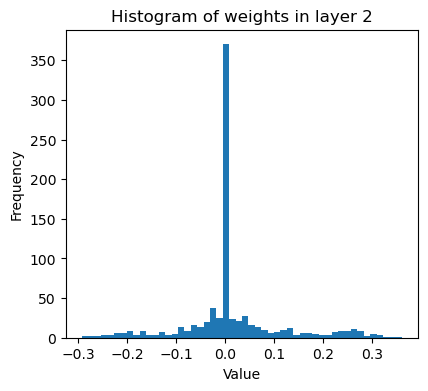

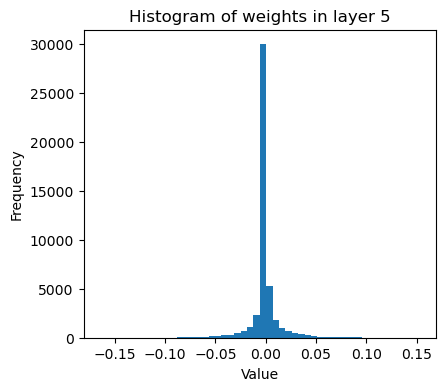

In [23]:
def plot_weights_histograms(model):
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if weights:  #ensure there exist weights
            weight_values = weights[0].flatten()
            bias_values = weights[1].flatten() if len(weights) > 1 else np.array([])

            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.hist(weight_values, bins=50)
            plt.title(f'Histogram of weights in layer {i+1}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')

plt.show()
plot_weights_histograms(model_with_l2)

In [24]:
import pandas as pd
layer_data = []
for layer in model.layers:
    # make sure it's not output layer
    if hasattr(layer, 'output_shape'):
        output_shape = layer.output_shape
    else:
        output_shape = layer.output.shape

    layer_data.append({
        'Layer Name': layer.name,
        'Layer Type': layer.__class__.__name__,
        'Output Shape': output_shape  
    })

# Change all into dataframe
layer_info_df = pd.DataFrame(layer_data)
print(layer_info_df)


      Layer Name    Layer Type        Output Shape
0  input_layer_3    InputLayer   (None, 28, 28, 1)
1          conv1        Conv2D  (None, 24, 24, 64)
2          pool1  MaxPooling2D  (None, 12, 12, 64)
3      flatten_3       Flatten        (None, 9216)
4        dense_3         Dense          (None, 10)


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the CNN model
input_layer = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, (10, 10), strides=(2,2), activation='relu', name='conv1')(input_layer)
x = layers.MaxPooling2D((2, 2), name='pool1')(x)
x = layers.Flatten()(x)
output_layer = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        logs['test_accuracy'] = test_acc
        #print(f'\nTest accuracy after epoch {epoch + 1}: {test_acc:.4f}')
# Train the model for 20 epochs and store history
validation_size = 5000
total_train_size = 55000  # 設置為55,000
validation_split = validation_size / total_train_size  # 計算驗證集佔比

# 訓練模型
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=validation_split, verbose=0, callbacks=[TestAccuracyCallback()])

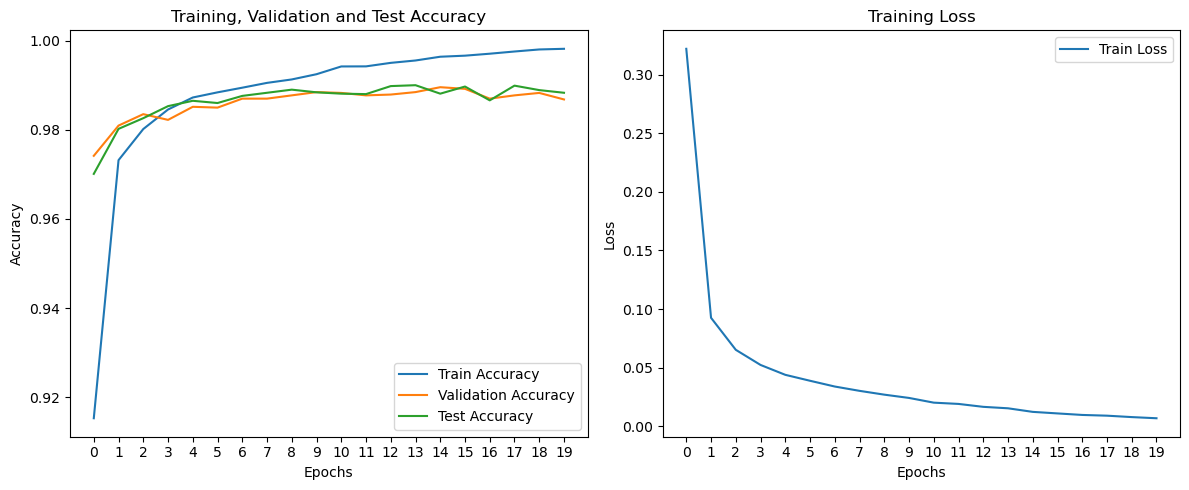

In [2]:
# Plot the accuracy 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['test_accuracy'], label='Test Accuracy') 
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(history.history['accuracy'])))
plt.legend()

# plot loss function
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(history.history['accuracy'])))
plt.legend()

plt.tight_layout()
plt.show()